## Data exploration:
1. Extract json content to dataframe (panda)
2. Basic statictics analysis on the data
3. Conclusion

### Usefull links
- [dataset](https://signate.jp/competitions/256/data)
- [signate tuto](https://signate.jp/competitions/142/tutorials/9)
- [frame extraction - signate](https://signate.jp/competitions/256/discussions/tutorial-how-to-decode-the-training-videos-to-training-images)
- [frame label to yolo format-signate](https://signate.jp/competitions/256/discussions/tutorial-how-to-convert-labels-from-multiple-jsons-to-a-single-txt-file)
- [panda and list as cat](https://stackoverflow.com/questions/37125174/accessing-every-1st-element-of-pandas-dataframe-column-containing-lists)
- [team google docs](https://docs.google.com/document/d/1UPNw9wHmnnpVCJI8LBmBkJG1lyKzn-Hhh1flNZ5k2Eo/edit)

In [1]:
import os
import pandas as pd
import numpy as np
import json

### 1] Extract json to dataframe

In [2]:
# Generate one file for all video
## Get absolute path / or specify path for data
_path_for_data = os.getcwd()
train_annotations_path = os.path.join(_path_for_data, 'train_annotations')
train_annotations_files = os.listdir(train_annotations_path)

In [3]:
# Global parameters (note the spelling on Svehicle)
IMAGE_SIZE = (1936,1216)
IMAGE_AREA = IMAGE_SIZE[0]*IMAGE_SIZE[1]
CATEGORIES = ['Car', 'Pedestrian', 'Truck', 'Signal', 'Signs', 'Bicycle', 'Motorbike', 'Bus', 'Svehicle', 'Train']

# Dataframe content:
column_names = ["video_id", "frame_id", "detected_cat", "tracking_id", "bbox"]
annot_df = pd.DataFrame(columns = column_names)

Extract of 1 video by 1 video, because 600x25 is too heavy to process as once.

Here we extract in order::
1. The frames
2. The frame_id
3. The detected category
4. Tracking index and bbox

In [4]:
def extract_frame(frame, content_list, video_id, frame_id):
    """Extract the content of the frame into the df dataframe."""
    for classe in CATEGORIES:
        try:
            for detected_cat in frame[classe]:
                # Add line to df
                content_list.append({"video_id":video_id, 
                                    "frame_id":frame_id,
                                    "detected_cat":classe, 
                                    "tracking_id":detected_cat['id'], 
                                    "bbox":detected_cat['box2d']})
        except Exception as e:
            pass

In [5]:
# Select the video to explore:
train_annotations_file = train_annotations_files[2]
content_list = []

with open(os.path.join(train_annotations_path, train_annotations_file)) as f:
    video_id = train_annotations_file.split('/')[-1].split('\\')[-1].split('.')[0].split('_')[1]
    
    # Load json and split frame
    annotation = json.load(f)
    frames = annotation["sequence"]
    print("Extracting video train_{} a total of {} frames...".format(video_id, len(frames)))

    # Extract each frame content into dataset
    for frame_id, frame in enumerate(frames):
        extract_frame(frame, content_list, video_id, frame_id)
    
    # Writting in the dataframe
    annot_df = annot_df.append(content_list)
    print("...Done!")

Extracting video train_10 a total of 600 frames...
...Done!


### 3] WIP Basic exploration

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
print("Shape of Dataframe: {}".format(annot_df.shape))
print(annot_df.info())

Shape of Dataframe: (7104, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7104 entries, 0 to 7103
Data columns (total 5 columns):
video_id        7104 non-null object
frame_id        7104 non-null object
detected_cat    7104 non-null object
tracking_id     7104 non-null object
bbox            7104 non-null object
dtypes: object(5)
memory usage: 333.0+ KB
None


In [8]:
# Generate area and ratio features
annot_df['area'] = (annot_df.bbox.str[2] - annot_df.bbox.str[0])*(annot_df.bbox.str[3] - annot_df.bbox.str[1])
annot_df['ratio'] = round(annot_df['area'] / IMAGE_AREA * 100, 4) 

In [9]:
annot_df.head()

,video_id,frame_id,detected_cat,tracking_id,bbox,area,ratio
0,10,0,Car,5846,"[1073, 542, 1146, 613]",5183,0.2202
1,10,0,Car,5686,"[883, 561, 1008, 662]",12625,0.5363
2,10,0,Car,5840,"[714, 542, 782, 598]",3808,0.1618
3,10,0,Car,5847,"[1041, 557, 1076, 585]",980,0.0416
4,10,0,Car,5842,"[998, 549, 1025, 589]",1080,0.0459


In [10]:
# How many object by frame ?
max_detected = annot_df.groupby('frame_id').detected_cat.count().max()
min_detected = annot_df.groupby('frame_id').detected_cat.count().min()
ave_detected = annot_df.groupby('frame_id').detected_cat.count().mean()
print("Detection by frame: average: {} | max: {} | min: {}".format(ave_detected, max_detected, min_detected))

Detection by frame: average: 11.84 | max: 35 | min: 3


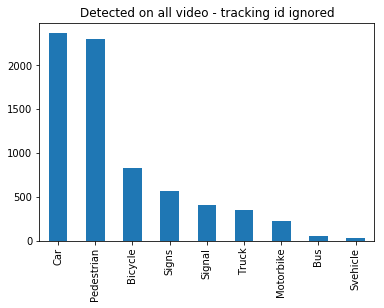

In [11]:
annot_df['detected_cat'].value_counts().plot(kind='bar',x='cat',y='count', title="Detected on all video - tracking id ignored")

In [12]:
# Average ratio bbox by class
annot_df.groupby('detected_cat').ratio.mean()

detected_cat
Bicycle       0.257084
Bus           2.427619
Car           0.724536
Motorbike     0.366786
Pedestrian    0.122888
Signal        0.048904
Signs         0.062389
Svehicle      2.253606
Truck         1.133390
Name: ratio, dtype: float64

In [13]:
# Find unique ID
unique_id = annot_df['tracking_id'].nunique()
print("This video contains {} distincs objects".format(unique_id))

This video contains 483 distincs objects


In [14]:
# Count repeated tracking id
# "Objects with 3 or more frames in each video"
reapeate_more_than_3 = annot_df.groupby('tracking_id').tracking_id.count().apply(lambda x: True if x>2 else False)
print("There are {} objects that are not repeated more than 3 times.".format(reapeate_more_than_3.values.tolist().count(False)))

There are 91 objects that are not repeated more than 3 times.


In [15]:
# Longuest repeatition
annot_df.groupby('tracking_id').tracking_id.count().nlargest(10)

tracking_id
5686     600
38704    181
204      173
680       88
5904      79
681       78
202       69
218       68
5880      68
670       67
Name: tracking_id, dtype: int64

In [16]:
print("One car is tracked in all frame of the video - maybe need to check the video")
annot_df.loc[annot_df['tracking_id'] == 5686].head()

One car is tracked in all frame of the video - maybe need to check the video


,video_id,frame_id,detected_cat,tracking_id,bbox,area,ratio
1,10,0,Car,5686,"[883, 561, 1008, 662]",12625,0.5363
17,10,1,Car,5686,"[885, 583, 1006, 690]",12947,0.5500
40,10,2,Car,5686,"[880, 589, 1009, 690]",13029,0.5534
60,10,3,Car,5686,"[881, 583, 1011, 688]",13650,0.5798
79,10,4,Car,5686,"[884, 582, 1014, 688]",13780,0.5853


In [17]:
# Other analysis?
# - tracking id lenght / class
# - ??